In [312]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import DirectoryLoader, PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
import operator
from typing import List
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, END
from langchain.output_parsers import PydanticOutputParser
from IPython.display import Image, display
from langchain_community.tools.tavily_search import TavilySearchResults
import string


In [94]:
load_dotenv()

os.environ['OPENAI_API_KEY']=os.getenv('OPENAI_API_KEY')
os.environ['TAVILY_API_KEY']=os.getenv('TAVILY_API_KEY')

In [95]:
model = ChatOpenAI()
model.invoke("Hi")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-Bgw57v9mMwVWWfeOR8CMSTWtD2bqe', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--86b07707-fb99-404e-957d-856de16ab8d6-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [96]:
embeddings = OpenAIEmbeddings()
len(embeddings.embed_query("hi"))

1536

In [97]:
loader=DirectoryLoader("./data",glob="*.pdf",loader_cls=PyPDFLoader)
docs=loader.load()
docs[0].page_content

'Artificial Intelligence has revolutionized healthcare by enabling faster and more accurate \ndiagnosis of diseases. Machine learning models analyze medical images like X-rays and \nMRIs to detect anomalies that may be missed by the human eye. AI-driven tools also help \npersonalize treatment plans by predicting patient responses to different therapies, \nimproving outcomes and reducing costs in hospitals worldwide. \nIn the field of natural language processing, AI has made significant strides in understanding \nand generating human language. Technologies like GPT models can compose coherent \ntext, translate languages instantly, and even engage in meaningful conversations. This \nprogress has enhanced virtual assistants, automated customer support, and content \ncreation, making communication more accessible across languages and cultures. \nEthical considerations in AI development are becoming increasingly important as these \ntechnologies impact society. Issues such as algorithmic bi

In [98]:
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=50
)

In [99]:
new_docs=text_splitter.split_documents(documents=docs)
new_docs

[Document(metadata={'producer': 'Microsoft® Word for Microsoft 365', 'creator': 'Microsoft® Word for Microsoft 365', 'creationdate': '2025-06-09T02:39:52+02:00', 'author': 'Raza Mehar', 'moddate': '2025-06-09T02:39:52+02:00', 'source': 'data\\ai.pdf', 'total_pages': 1, 'page': 0, 'page_label': '1'}, page_content='Artificial Intelligence has revolutionized healthcare by enabling faster and more accurate \ndiagnosis of diseases. Machine learning models analyze medical images like X-rays and'),
 Document(metadata={'producer': 'Microsoft® Word for Microsoft 365', 'creator': 'Microsoft® Word for Microsoft 365', 'creationdate': '2025-06-09T02:39:52+02:00', 'author': 'Raza Mehar', 'moddate': '2025-06-09T02:39:52+02:00', 'source': 'data\\ai.pdf', 'total_pages': 1, 'page': 0, 'page_label': '1'}, page_content='MRIs to detect anomalies that may be missed by the human eye. AI-driven tools also help \npersonalize treatment plans by predicting patient responses to different therapies,'),
 Document(m

In [100]:
doc_string=[doc.page_content for doc in new_docs]
doc_string

['Artificial Intelligence has revolutionized healthcare by enabling faster and more accurate \ndiagnosis of diseases. Machine learning models analyze medical images like X-rays and',
 'MRIs to detect anomalies that may be missed by the human eye. AI-driven tools also help \npersonalize treatment plans by predicting patient responses to different therapies,',
 'improving outcomes and reducing costs in hospitals worldwide. \nIn the field of natural language processing, AI has made significant strides in understanding',
 'and generating human language. Technologies like GPT models can compose coherent \ntext, translate languages instantly, and even engage in meaningful conversations. This',
 'progress has enhanced virtual assistants, automated customer support, and content \ncreation, making communication more accessible across languages and cultures.',
 'Ethical considerations in AI development are becoming increasingly important as these \ntechnologies impact society. Issues such as alg

In [101]:
len(doc_string)

10

In [102]:
db=Chroma.from_documents(new_docs,embeddings)
retriever=db.as_retriever(search_kwargs={"k": 3})

In [103]:
class TopicSelectionParser(BaseModel):
    Topic:str=Field(description="selected topic")
    Reasoning:str=Field(description='Reasoning behind topic selection')

In [104]:
parser=PydanticOutputParser(pydantic_object=TopicSelectionParser)
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"description": "selected topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}\n```'

In [105]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [106]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [167]:
def supervisor_node(state: AgentState):
    print("Calling Supervisor node...")
    question = state["messages"][-1]

    template = """
    Classify the user's query into one of the following categories: [RAG, Web, Not Related].

    - If the query is about AI or Artificial Intelligence, or relates to tasks handled by a retrieval-augmented generation (RAG) system such as answering questions using internal knowledge, classify it as **RAG**.
    - If the query includes phrases like "find the latest", "search for", "look up", or anything requiring real-time internet access, classify it as **Web**.
    - Otherwise, classify it as **Not Related**.

    Only respond with one of these category names: RAG, Web, or Not Related.

    User query: {question}
    {format_instructions}
    """

    prompt = PromptTemplate(
        template=template,
        input_variables=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )

    chain = prompt | model | parser
    response = chain.invoke({"question": question})

    return {"messages": [response.Topic]}

In [168]:
def rag_node(state: AgentState):
    print("Calling RAG node...")
    question = state["messages"][0]

    prompt = PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        input_variables=['context', 'question']
    )

    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )

    result = rag_chain.invoke(question)
    return {"messages": [result]}

In [313]:
def web_crawl_node(state: AgentState):
    print("Calling Web Crawl Node...")

    tavily_key = os.getenv("TAVILY_API_KEY") 
    if not tavily_key:
        return {"messages": ["Error: Tavily API key not found."]}

    tool = TavilySearchResults(tavily_api_key=tavily_key)
    question = state["messages"][0]
    results = tool.invoke({"query": question})

    if isinstance(results, list) and results:
        top_links = "\n".join(
            f"- {item.get('title', 'No Title')}: {item.get('url', 'No URL')}"
            for item in results[:3]
        )
        return {"messages": [top_links]}
    else:
        return {"messages": ["No relevant search results found."]}

In [314]:
def llm_node(state: AgentState):
    print("Calling LLM node...")
    question = state["messages"][0]

    complete_query = (
        "Answer the following question with your knowledge of the real world. "
        "If you don't know the answer, please just say 'I don't know'.\n\n"
        "User question: " + question
    )
    response = model.invoke(complete_query)

    return {"messages": [response.content]}

In [315]:
def router(state: AgentState):
    print("Calling the Router...")
    last_message = state["messages"][0]
    message_lower = last_message.lower()

    ai_keywords = [
        "ai", "artificial intelligence"]

    web_keywords = [
        "search", "new", "find", "latest", "lookup", "look up", "online", "on the net", "on the internet"]

    if any(keyword in message_lower for keyword in ai_keywords):
        return "RAG"
    elif any(keyword in message_lower for keyword in web_keywords):
        return "Web"
    else:
        return "LLM"

In [393]:
def validator_node(state: AgentState):
    print("Calling Validator node...")
    last_message = state["messages"][-1]

    normalized_msg = last_message.strip().lower().translate(str.maketrans('', '', string.punctuation))

    failure_responses = {
        "i dont know",
        "sorry i dont know"
    }

    if normalized_msg in failure_responses:
        print("Validation failed.")
        return {"messages": [normalized_msg]}
    else:
        print("Validation passed.")
        return {"messages": [last_message]}

In [412]:
def re_router(state: AgentState):
    global COUNTER
    if COUNTER > 2:
        print(f"Maximum limit of {COUNTER} exhausted")
        COUNTER = 0
        original_question = state["messages"][0]
        state["messages"][-1] = original_question
        return "Final"

    COUNTER += 1

    print("Calling the Re-router...")
    last_message = state["messages"][-1]
    message_lower = last_message.strip().lower()

    failure_responses = {
        "i dont know",
        "sorry i dont know"
    }

    if message_lower in failure_responses:
        print(f"Attempt {COUNTER}. Re-routing to Supervisor...")
        original_question = state["messages"][0]
        state["messages"][-1] = original_question
        return "Supervisor"
    else:
        print("Re-routing to Final...")
        COUNTER = 0
        return "Final"


In [413]:
def final_node(state: AgentState):
    return {"messages": [state['messages'][-1]]}

In [414]:
workflow = StateGraph(AgentState)

workflow.add_node("Supervisor", supervisor_node)
workflow.add_node("RAG", rag_node)
workflow.add_node("Web", web_crawl_node)
workflow.add_node("LLM", llm_node)
workflow.add_node("Validator", validator_node)
workflow.add_node("Final", final_node)

workflow.set_entry_point("Supervisor")

workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG": "RAG",
        "Web": "Web",
        "LLM": "LLM",
    }
)

workflow.add_edge("RAG", "Validator")
workflow.add_edge("Web", "Validator")
workflow.add_edge("LLM", "Validator")

workflow.add_conditional_edges(
    "Validator", 
    re_router, 
    {
        "Supervisor": "Supervisor", 
        "Final": "Final"
    }
)

workflow.add_edge("Final", END)

app=workflow.compile()

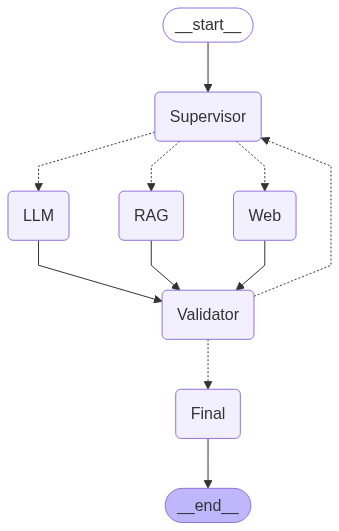

In [415]:
display(Image(app.get_graph().draw_mermaid_png()))

In [421]:
state={"messages":["AI"]}
result = app.invoke(state)
result["messages"][-1]

Calling Supervisor node...
Calling the Router...
Calling RAG node...
Calling Validator node...
Validation passed.
Calling the Re-router...
Re-routing to Final...


'AI has significantly improved the speed and accuracy of diagnosing diseases in the healthcare industry by using machine learning models to analyze medical images like X-rays. The integration of AI into emerging hardware technologies, such as quantum computing, is aiming to build AI systems that respect privacy and promote social justice.'